In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration
from sklearn.preprocessing import MinMaxScaler
import scipy
import time
import multiprocessing

In [2]:
num_model_parameters = 3
num_strikes = 16
num_maturities = 16


num_input_parameters = 3
num_output_parameters = num_maturities*num_strikes
learning_rate = 0.001
num_steps = 50
batch_size = 6
num_neurons = 40

#initial values
S0 = 1.0
V0 = 0.1
r = 0.05


contract_bounds = np.array([[0.6*S0,1.2*S0],[1,10]]) #bounds for K,T
model_bounds = np.array([[0.01,0.15],[0,1],[-1,0]]) #bounds for alpha,beta,rho, make sure alpha>0, beta,rho \in [0,1]

"""
Note: The grid of stirkes and maturities is equidistant here put could be choosen differently for real world application.
Note: For the code below to striktly follow the bounds specified above make sure that *_distance x num_* is less than half the distance from the highest to lowest * (* = strikes/maturities). 
"""
maturities_distance = (contract_bounds[1,1]-contract_bounds[1,0])/(2*num_maturities) 
strikes_distance = (contract_bounds[0,1]-contract_bounds[0,0])/(2*num_strikes)

strikes = np.linspace(contract_bounds[0,0],contract_bounds[0,0]+num_strikes*strikes_distance,num_strikes)
maturities = np.linspace(contract_bounds[1,0],contract_bounds[1,0]+num_maturities*maturities_distance,num_maturities)

In [3]:
X = tf.placeholder(tf.float32, [None, num_input_parameters])
y = tf.placeholder(tf.float32, [None, num_output_parameters])

In [4]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

def sabr(alpha,beta,T,W,Z,V0,S0):
    #print(beta)
    #assert(beta>0 and beta<1)

    def mu2(V,i,k):
        return 0.0
    
    def sigma2(V,i,k):
        return np.multiply(alpha,V)
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(V[i,k],np.power(np.maximum(0.0,S),beta))
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

def reverse_transform_X(X_scaled):
    X = np.zeros(X_scaled.shape)
    for i in range(num_input_parameters):
        X[:,i] = X_scaled[:,i]*(model_bounds[i][1]-model_bounds[i][0]) + model_bounds[i][0]
    return X

def price_pred(alpha,beta,rho,n,dim,T,K,V0,S0):
    W,Z = corr_brownian_motion(n,T,dim,rho)
    S,V = sabr(alpha,beta,T,W,Z,V0,S0)
    S_T = S[:,n]
    P = np.exp(-r*T) * np.mean(np.maximum(S_T-K,np.zeros(dim)))
    
    return P

def next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds):
    X_scaled = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))

    X_scaled[:,0] = uniform.rvs(size=batch_size) #alpha
    X_scaled[:,1] = uniform.rvs(size=batch_size) #beta
    X_scaled[:,2] = uniform.rvs(size=batch_size) #rho

    X = reverse_transform_X(X_scaled)

    n = 100
    dim = 50
    for i in range(batch_size):
        for j in range(num_maturities):
            for k in range(num_strikes):
                y[i,j*num_strikes+k] = price_pred(X[i,0],X[i,1],X[i,2],n,dim,maturities[j],strikes[k],V0,S0)

    return X_scaled,y

In [5]:
#Layers
hidden1 = fully_connected(X, num_neurons, activation_fn=tf.nn.elu)
bn1 = tf.nn.batch_normalization(hidden1, 0, 1, 0, 1, 0.000001)
hidden2 = fully_connected(bn1, num_neurons, activation_fn=tf.nn.elu)
bn2 = tf.nn.batch_normalization(hidden2, 0, 1, 0, 1, 0.000001)
hidden3 = fully_connected(bn2, num_neurons, activation_fn=tf.nn.elu)
bn3 = tf.nn.batch_normalization(hidden3, 0, 1, 0, 1, 0.000001)
hidden4 = fully_connected(hidden3, num_neurons, activation_fn=tf.nn.elu)
bn4 = tf.nn.batch_normalization(hidden4, 0, 1, 0, 1, 0.000001)

outputs = fully_connected(bn4, num_output_parameters, activation_fn=None)

Instructions for updating:
Please use `layer.__call__` method instead.


In [6]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [7]:
num_cpu = multiprocessing.cpu_count()
config = tf.ConfigProto(device_count={ "CPU": num_cpu },
                                        inter_op_parallelism_threads=num_cpu,
                                        intra_op_parallelism_threads=2,
                                        )

with tf.Session(config=config) as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        
        X_batch,Y_batch = next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds)
        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        if iteration % 1 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
    
    saver.save(sess, "./models/sabr_dnn")

0 	RMSE: 0.20975745
1 	RMSE: 0.20169902
2 	RMSE: 0.19308044
3 	RMSE: 0.18806581
4 	RMSE: 0.18512206
5 	RMSE: 0.17711806
6 	RMSE: 0.1602016
7 	RMSE: 0.1578678
8 	RMSE: 0.14880206
9 	RMSE: 0.1497416
10 	RMSE: 0.13001387
11 	RMSE: 0.13100623
12 	RMSE: 0.12065178
13 	RMSE: 0.11396853
14 	RMSE: 0.107391454
15 	RMSE: 0.10064211
16 	RMSE: 0.0976789
17 	RMSE: 0.08657799
18 	RMSE: 0.0859502
19 	RMSE: 0.07501913
20 	RMSE: 0.07914211
21 	RMSE: 0.07509269
22 	RMSE: 0.07035697
23 	RMSE: 0.05446976
24 	RMSE: 0.049808707
25 	RMSE: 0.06257817
26 	RMSE: 0.052053373
27 	RMSE: 0.056298096
28 	RMSE: 0.058755588
29 	RMSE: 0.0555214
30 	RMSE: 0.05022676
31 	RMSE: 0.04088062
32 	RMSE: 0.04158993
33 	RMSE: 0.039416183
34 	RMSE: 0.04404074
35 	RMSE: 0.04502535
36 	RMSE: 0.05200398
37 	RMSE: 0.037077744
38 	RMSE: 0.032489616
39 	RMSE: 0.0323036
40 	RMSE: 0.032629903
41 	RMSE: 0.032051396
42 	RMSE: 0.031521205
43 	RMSE: 0.03263258
44 	RMSE: 0.034814633
45 	RMSE: 0.032689665
46 	RMSE: 0.041696798
47 	RMSE: 0.0322

In [8]:
def prices_grid(theta):
    prices_true = np.zeros((1,num_output_parameters))
    n = 100
    dim = 200
    for i in range(num_maturities):
        for j in range(num_strikes):        
            prices_true[0,i*num_strikes+j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
    return prices_true

In [19]:
def predict_theta(prices_ture):   
    
    def NNprediction(theta):
        x = np.zeros((1,len(theta)))
        x[0,:] = theta
        return sess.run(outputs,feed_dict={X: x})
    def NNgradientpred(x):
        x = np.asarray(x)
        grad = np.zeros((num_output_parameters,num_input_parameters))
        
        delta = 0.000001
        for i in range(num_input_parameters):
            h = np.zeros(x.shape)
            h[0,i] = delta
            
            #two point gradient
            #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

            #four point gradient
            grad[:,i] = (-sess.run(outputs,feed_dict={X: x+2*h})+8*sess.run(outputs,feed_dict={X: x+h})-8*sess.run(outputs,feed_dict={X: x-h}) +sess.run(outputs,feed_dict={X: x-2*h}))/12/delta

        return np.mean(grad,axis=0)

    def CostFuncLS(theta):
        
        return np.sqrt(np.mean(np.power((NNprediction(theta)-prices_true.flatten())[0],2),axis=0))


    def JacobianLS(theta):
        x = np.zeros((1,len(theta)))
        x[0,:] = theta
        return NNgradientpred(x).T

    with tf.Session() as sess:                          
        saver.restore(sess, "./models/sabr_dnn")      
        
        init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
        bnds = ([model_bounds[0,0],model_bounds[1,0],model_bounds[2,0]],[model_bounds[0,1],model_bounds[1,1],model_bounds[2,1]])


        I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,bounds=bnds,gtol=1E-15,xtol=1E-15,verbose=1)

    theta_pred = I.x
    
    return theta_pred

In [10]:
theta_true = [0.1,0.5,-0.5]
prices_true = prices_grid(theta_true)

In [11]:
theta_pred = predict_theta(prices_true)

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 1.1378e-02, final cost 1.1378e-02, first-order optimality 4.48e-03.


In [12]:
print(theta_true)
print(theta_pred)

[0.1, 0.5, -0.5]
[ 0.14652966  0.34785433 -0.82061593]


In [13]:
prices_true = np.zeros((num_maturities,num_strikes))
prices_pred = np.zeros((num_maturities,num_strikes))
init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
prices_trash = np.zeros((num_maturities,num_strikes))
n = 100
dim = 300
for i in range(num_maturities):
    for j in range(num_strikes):        
        prices_true[i,j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_pred[i,j] = price_pred(theta_pred[0],theta_pred[1],theta_pred[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_trash[i,j] = price_pred(init[0],init[1],init[2],n,dim,maturities[i],strikes[j],V0,S0)

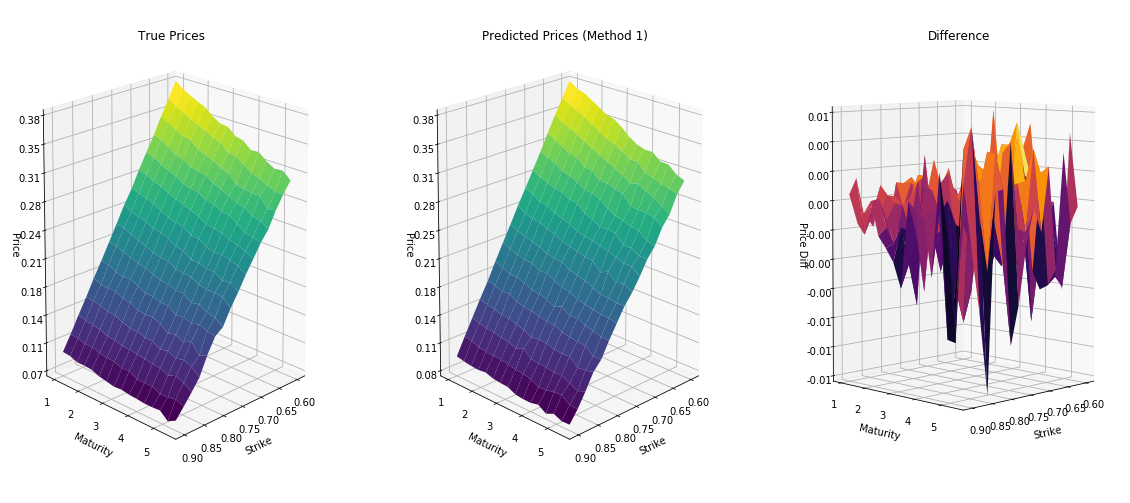

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(20, 9))

T_ = np.zeros((num_maturities,num_strikes))
K_ = np.zeros((num_maturities,num_strikes))
for i in range(num_strikes):
    for j in range(num_maturities):
        T_[j,i] = maturities[j]
for j in range(num_maturities):   
    for i in range(num_strikes):
        K_[j,i] = strikes[i]

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X=K_, Y=T_, Z=prices_true, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')
ax1.set_title('True Prices')
ax1.view_init(15, 45)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=prices_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices (Method 1)')
ax2.view_init(15, 45)


ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=prices_true-prices_pred, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity')
ax3.set_zlabel('Price Diff')
ax3.set_title('Difference')
ax3.view_init(5, 45)
"""
ax3 = fig.add_subplot(133)
ax3.imshow(prices_true-prices_pred,cmap='Blues_r')
ax3.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax3.set_xticklabels(np.around(strikes,decimals=1))
ax3.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax3.set_yticklabels(np.around(maturities,decimals=1))
"""
plt.savefig('prices_dnn.pdf') 
plt.show()


In [15]:
mean_err = np.mean(np.mean(np.abs(prices_true-prices_pred),axis=0),axis=0)
mean_err_init = np.mean(np.mean(np.abs(prices_true-prices_trash),axis=0),axis=0)
mean_true_price = np.mean(np.mean(np.abs(prices_true),axis=0),axis=0)
print("MSE: ",mean_err)
print("MSE Init: ",mean_err_init)
print("Percent of avg True Price: ",mean_err/mean_true_price*100)

MSE:  0.0019169658392140083
MSE Init:  0.0019288158697717936
Percent of avg True Price:  0.8997692019182957


### Create Grid of Model Parameters and corresponding Prices

In [16]:
bb = 2
num_thetas = np.power(bb,num_model_parameters)
thetas_true = np.zeros((num_thetas,num_model_parameters))

for i in range(bb):
    for j in range(bb):
        for k in range(bb):
            thetas_true[i*bb*bb+j*bb+k,0] = model_bounds[0,0]+ k *(model_bounds[0,1]-model_bounds[0,0])/(bb-1)
            thetas_true[i*bb*bb+j*bb+k,1] = model_bounds[1,0]+ j *(model_bounds[1,1]-model_bounds[1,0])/(bb-1)
            thetas_true[i*bb*bb+j*bb+k,2] = model_bounds[2,0]+ i *(model_bounds[2,1]-model_bounds[2,0])/(bb-1)


In [20]:
thetas_pred = np.zeros((num_thetas,num_model_parameters))
for i in range(num_thetas):
    thetas_pred[i,:] = predict_theta(prices_grid(thetas_true[i,:]).flatten())

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 1.2817e-02, final cost 1.2817e-02, first-order optimality 5.83e-03.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 9.4481e-03, final cost 9.4481e-03, first-order optimality 5.83e-03.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 3.6343e-03, final cost 3.6343e-03, first-order optimality 5.15e-03.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 28, initial cost 1.5378e-03, final cost 1.5378e-03, first-order optimality 3.32e-03.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 9.9916e-03, final cost 

In [30]:
diff = np.mean(np.mean(np.power(thetas_pred - thetas_true,2),axis=0),axis=0)
print(thetas_true)
print(thetas_pred)

[[ 0.01  0.   -1.  ]
 [ 0.15  0.   -1.  ]
 [ 0.01  1.   -1.  ]
 [ 0.15  1.   -1.  ]
 [ 0.01  0.    0.  ]
 [ 0.15  0.    0.  ]
 [ 0.01  1.    0.  ]
 [ 0.15  1.    0.  ]]
[[ 0.06758256  0.09350728 -0.59380881]
 [ 0.0102146   0.54819672 -0.70508085]
 [ 0.05117374  0.59956038 -0.20815504]
 [ 0.06737589  0.82471909 -0.01702023]
 [ 0.10931423  0.33759617 -0.66803801]
 [ 0.11644844  0.76146875 -0.63768728]
 [ 0.02851184  0.21463501 -0.84979025]
 [ 0.05557981  0.52604179 -0.34790998]]


In [29]:
rel_error = np.mean(np.abs(thetas_pred - thetas_true),axis=1)/np.abs(np.mean(thetas_true,axis=1))
print("Relative Error: ",  rel_error )

Relative Error:  [  0.56291012   1.15635443 123.34583186   8.27256525 110.4948412
   9.55138392   1.63729413   0.7967725 ]


In [ ]:
prices_grid_true = np.zeros((num_thetas,num_maturities,num_strikes))
prices_grid_pred = np.zeros((num_thetas,num_maturities,num_strikes))
n = 100
dim = 100
for i in range(num_thetas):
    for j in range(num_maturities):
        for k in range(num_strikes):
            prices_grid_true[i,j,k] = price_pred(thetas_true[i,0],thetas_true[i,1],thetas_true[i,2],n,dim,maturities[i],strikes[j],V0,S0)
            prices_grid_pred[i,j,k] = price_pred(thetas_pred[i,0],thetas_pred[i,1],thetas_pred[i,2],n,dim,maturities[i],strikes[j],V0,S0)

In [ ]:
ax = plt.imshow(prices_grid_true-prices_grid_pred)

plt.show()